# Tutorial adversarial MIP attacks : Sparse and invisible adversarial attacks using MIP Optimization

In this notebook we are dealing specifically with sparse adversarial attacks for neural networks with feedforward, convolutional, and residual layers. We want to modify the smallest amount of pixels in order to change the decision. We propose a new technique to craft adversarial examples aiming at minimizing $\ell_1$ distance to the original image regularized by the Total variation (TV) function. This will favor the change of pixels in the region of high variation making the attacks almost invisible.

This notebook implements main methods to generate such adversarial MIPs examples in a white box setting, with the CIFAR10 and Mnist datasets using several neural networks used in [Eran](https://files.sri.inf.ethz.ch/eran/docs/eran_manual.pdf), in order to compare their efficiency in terms of accuracy, solution quality and computation time.



We can use the CIFAR10 dataset, in which there ares images belonging to $c = 10$ possible labels {"airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck"}.

<center>
<img src="https://www.cs.umd.edu/~tomg/img/free/viz_9985_10000_small.png" 
alt="CIFAR10 data" width="360" height="270" border="1"/>
<p style="text-align: center;"> <i>Illustration from the Adversarial Training for Free! web site </i> https://www.cs.umd.edu/~tomg/projects/free/</p>
</center>

Or we can use the Mnist dataset, in which there ares images belonging to $c = 10$ possible labels { "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "sex",
            "seven",
            "eight",
            "nine"}.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" 
alt="Mnist data" width="360" height="270" border="1"/>
<p style="text-align: center;"> <i>Illustration from the Adversarial Training for Free! web site </i> https://en.wikipedia.org/wiki/MNIST_database</p>
</center>


Are implemented:
- The MIP-ReLUplex-gurobi attacks using $L_{inf}$ distance measure
- The MIP-ReLUplex-gurobi attacks using $L_2$ distance measure
- The MIP-ReLUplex-gurobi attacks using $L_1$  distance measure
- The MIP-ReLUplex-gurobi attacks using $L_1$  distance measure + TV


In [2]:
import warnings
warnings.filterwarnings("ignore")
import argparse
import csv
import os
import sys
import traceback

import matplotlib.pyplot as plt
import numpy as np
import onnxruntime.backend as rt
import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms
from onnx import helper

sys.path.insert(0, "./ELINA/python_interface/")
sys.path.insert(1, "./ERAN/")

from config import config
from ipynb.fs.full.ai_milp import *
from read_net_file import *

from eran import ERAN

is_tf_version_2 = tf.__version__[0] == "2"
if is_tf_version_2:
    tf = tf.compat.v1

2023-06-12 07:29:18.663385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-06-12 07:29:18.663434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-12 07:29:22.854459: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 07:29:22.949765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_

## Loading Data and trained neural network

The code can read neural networks in ONNX and TensorFlow formats directly. Both formats
are based on a computation graph. The nodes of this directed acyclic graph save the operations
and parameters needed for the execution. One of the main differences between the two formats
is in the representation of tensors. TensorFlow uses NHWC (batch, height, width, channel)
while ONNX uses NCHW representation

<center>
<img src="https://www.researchgate.net/publication/321259051/figure/fig1/AS:614329250496529@1523478915726/Artificial-neural-network-architecture-ANN-i-h-1-h-2-h-n-o.png" 
alt="Artificial neural network architecturea" width="360" height="270" border="1"/>
<p style="text-align: center;"> <i>Artificial neural network architecture! [web site] (https://www.researchgate.net/figure/Artificial-neural-network-architecture-ANN-i-h-1-h-2-h-n-o_fig1_321259051)
</center>
    
Choose a network, the name of a dataset, and the folder where the dataset is stored. The code determines the type of the selected network and reads it using TensorFlow or ONNX. Finally, the code sets the means and standard deviations of the dataset based on whether the network is normalized or not.

In [3]:
dataset = "mnist" #mnist ou cifar10
print("\n Dataset to test : ", dataset)
# uses the os module to get a list of networks in the dataset folder and selects one based on the index
idx_network = 2




domain = "deeppoly"
is_gpupoly = False

if dataset == "cifar10":
    class_names = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
else : 
    class_names = [
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "sex",
            "seven",
            "eight",
            "nine",
        ]
    
dataset_folder = "./data/" + dataset + "/nets/"

networks = os.listdir(dataset_folder)

for i, val in enumerate(networks):
    print(i, ":", val)


network = networks[idx_network]
print("\nNetwork to test : ", idx_network, ":", network)

filename = "./data/" + dataset + "/test.csv"

tf.reset_default_graph()
netname = dataset_folder + network
filename, file_extension = os.path.splitext(netname)

is_trained_with_pytorch = file_extension == ".pyt"
is_saved_tf_model = file_extension == ".meta"
is_pb_file = file_extension == ".pb"
is_tensorflow = file_extension == ".tf"
is_onnx = file_extension == ".onnx"

complete = True

if is_saved_tf_model or is_pb_file:
    print("is_saved_tf_model or is_pb_file")
else:
    if dataset == "mnist":
        num_pixels = 784
    elif dataset == "cifar10":
        num_pixels = 3072
    elif dataset == "acasxu":
        num_pixels = 5
    if is_onnx:
        model, is_conv = read_onnx_net(netname)
    else:
        sess = tf.Session()
        model, is_conv, means, stds = read_tensorflow_net(
            netname, num_pixels, is_trained_with_pytorch, is_gpupoly
        )

if is_conv:
    print("This network is conv")

is_normalized = False

if is_normalized:
    print("This network is normalized")
    means = [0.4914, 0.48220003, 0.4465]
    stds = [0.20230001, 0.19940001, 0.201]
else:
    means = [0, 0, 0]
    stds = [1, 1, 1]


 Dataset to test :  mnist
0 : mnist_relu_6_100.onnx
1 : mnist_relu_9_200.onnx
2 : mnist_relu_3_50.onnx
3 : convSmallRELU__Point.onnx
4 : convMedGRELU__Point.onnx
5 : mnist_relu_3_100.onnx
6 : mnist_conv_maxpool.onnx

Network to test :  2 : mnist_relu_3_50.onnx


In [4]:
eran = ERAN(model, is_onnx=is_onnx)

Mean of [0.] extracted from network
Std of [1.] extracted from network
This network has 110 neurons.


## Loading and Normalize data 

We reads in a CSV file containing test data for a given dataset, skips the first four rows, and extracts an image and its corresponding label from the next row. It then defines a function for displaying three images, and normalizes the image data. Depending on the dataset, it reshapes the input data, and then plots the original image and two additional images: one with added noise and one after an attack.

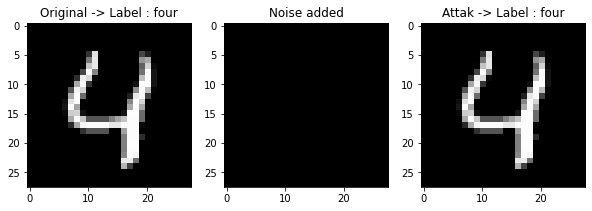

In [5]:
csvfile = open("./data/" + dataset + "/test.csv", "r")
tests = csv.reader(csvfile, delimiter=",")

next(tests)
next(tests)
next(tests)
next(tests)

test = next(tests)
image = np.float64(test[1 : len(test)]) / np.float64(255)
Image_label = np.int(test[0])
test_input = np.copy(image)


def imshow(img, fig):
    img = img
    npimg = img.numpy()
    fig.imshow(np.transpose(npimg, (1, 2, 0)))


def plot_attack_pred(original, label_name, attack, label_name_a):
    # show image and noise
    ax, fig = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
    fig[0].set_title("Original -> Label : " + label_name)
    imshow(torchvision.utils.make_grid(original), fig[0])
    noise = (original - attack).detach()
    fig[1].set_title("Noise added")
    imshow(10 * torchvision.utils.make_grid(noise), fig[1])
    fig[2].set_title("Attak -> Label : " + label_name_a)
    imshow(torchvision.utils.make_grid(attack), fig[2])
    plt.show()


if dataset == "cifar10":
    # input = np.array(test_input, dtype=np.float32).reshape([1, 32, 32, 3])
    input2 = torch.tensor(test_input).reshape((3, 32, 32)).type(torch.float)
elif dataset == "mnist":
    input = np.array(test_input, dtype=np.float32).reshape([1, 28, 28, 1])
    input2 = torch.tensor(test_input).reshape((1, 28, 28)).type(torch.float)

def normalize(image, means, stds, dataset):
    # normalization taken out of the network
    if len(means) == len(image):
        for i in range(len(image)):
            image[i] -= means[i]
            if stds != None:
                image[i] /= stds[i]
    elif dataset == "mnist" or dataset == "fashion":
        for i in range(len(image)):
            image[i] = (image[i] - means[0]) / stds[0]
    elif dataset == "cifar10":
        count = 0
        tmp = np.zeros(3072)
        for i in range(1024):
            tmp[count] = (image[count] - means[0]) / stds[0]
            count = count + 1
            tmp[count] = (image[count] - means[1]) / stds[1]
            count = count + 1
            tmp[count] = (image[count] - means[2]) / stds[2]
            count = count + 1

        is_gpupoly = False
        if is_conv and not is_gpupoly:
            for i in range(3072):
                image[i] = tmp[i]
        else:
            count = 0
            for i in range(1024):
                image[i] = tmp[count]
                count = count + 1
                image[i + 1024] = tmp[count]
                count = count + 1
                image[i + 2048] = tmp[count]
                count = count + 1


test_input = np.copy(image)
image_norm = np.copy(image)
normalize(image_norm, means, stds, dataset)


if dataset == "cifar10":
    input = np.array(image_norm, dtype=np.float32).reshape([1, 32, 32, 3])
    input2 = torch.tensor(image_norm).reshape((3, 32, 32)).type(torch.float)
elif dataset == "mnist":
    input = np.array(image_norm, dtype=np.float32).reshape([1, 28, 28, 1])
    input2 = torch.tensor(image_norm).reshape((1, 28, 28)).type(torch.float)



if is_conv:
    plot_attack_pred(
        torch.from_numpy(input).permute(0, 3, 1, 2).to("cpu"),
        class_names[Image_label],
        torch.from_numpy(input).permute(0, 3, 1, 2).to("cpu"),
        class_names[Image_label],
    )
else:
    plot_attack_pred(
        input2,
        class_names[Image_label],
        input2,
        class_names[Image_label],
    )

IRAN is used to get Lower and Upper Bounds of the neural networks.

In [6]:
specLB = np.copy(image_norm)
specUB = np.copy(image_norm)

eps    = 0.1

specLB = specLB - eps
specUB = specUB + eps

specLB[specLB < 0] = 0
specUB[specUB > 1] = 1

label_pred, nn, nlb, nub, failed_labels, x = eran.analyze_box(
    specLB, specUB, domain, 1, 1, config.use_default_heuristic, label=Image_label, testing=False, terminate_on_failure=False, max_milp_neurons=1000, complete=True
)
print(failed_labels)


if label_pred != -1:
    print("Label predicted :", label_pred, "-> ", class_names[label_pred])
else:
    print("-> network not robuste")

[0, 1, 2, 3, 5, 6, 7, 8, 9]
-> network not robuste


Choose the attack target :

In [7]:
adv_label = 9
print("Attack target :", adv_label, "-> ", class_names[adv_label])

Attack target : 9 ->  nine


## MIPs adversarial exemples

A classification model (e.g. Neural Network) with $c$  output nodes  (possible classes)
\begin{equation*}
	\begin{array}{cccl}
		f : {} & X \subseteq \mathbb{R}^p &  \longrightarrow&  \mathbb{R}^c  \\ %  \{0,1\}^c \\
		{} & x &  \longmapsto& f(x)
	\end{array}
	\label{function-neural-network}
\end{equation*}
The associated classification (or decision function) 
$$
C_f(x) = argmax_{k=1,\dots,c} f_k(x)
$$

Definition (Generic adversarial example): 
$\mathbf{a}_{f,x}$ is a generic adversarial example of $f$ at $x$ if $\mathbf{a}_{f,x}$ is a valid input close to $x$  and    
$$ 
C_f(x) \neq C_f(\mathbf{a}_{f,x})
\quad \mbox{ that is } \quad 
 \displaystyle  {c^\star} =  argmax_{k=1,\dots,c} f_k(x) \neq argmax_{k=1,\dots,c} f_k(\mathbf{a}_{f,x})
 $$

It is also possible to exactly minimize the  Adversarial  Distortion 
\begin{equation}
	\left\{
	\begin{array}{cclc}
		\displaystyle \min_{a \in X }  &D(x,a) &=&  \|x-a\|_p^p \\
		\text{subject to} & L\bigl(f(x),f(a)\bigr) \geq \alpha  &=&\displaystyle \max_{k \neq {c^\star}} f_k(a) >  f_{c^\star}(a) + \alpha
	\end{array}
	\right.
	\label{eq:MIP}
\end{equation}
In the particular case of a one hidden layer MLP with weighe $W$ and $V$ and biais $\beta$ and $\gamma$, function $f$ is
$$
	\begin{array}{rl}
		\displaystyle 
		z  & =  ReLU(W x + \beta)\\
		f(x) & = V z + \gamma
	\end{array}
	\quad \text{or}\quad 
	\begin{array}{rl}
		\displaystyle 
		h & = W x + \beta,\\
		z  & =  \max(h, 0)\\
		f(x) = s  & = V z + \gamma \,.
	\end{array}
$$
Based on that, the minimization of the  Adversarial  Distortion can be rewritten as a Mixed Integer Linear Program (MILP)


We create the MIP model :

In [8]:

relu_groups = None
use_milp = True
complete = True

is_nchw = False
partial_milp = -1
max_milp_neurons = 5000


counter, var_list, model = create_model(
    nn,
    specLB,
    specUB,
    nlb,
    nub,
    relu_groups,
    nn.numlayer,
    use_milp,
    is_nchw,
    partial_milp,
    max_milp_neurons,
)

num_var = len(var_list)
output_size = num_var - counter

model.addConstr(var_list[counter + adv_label] >= var_list[counter + Image_label] + 0.1)
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 0])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 1])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 2])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 3])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 4])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 5])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 6])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 7])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 8])
#model.addConstr(var_list[counter + adv_label] >= var_list[counter + 9])


create_model -
Set parameter Username
Set parameter TokenServer to value "calcul-02"
Set parameter FeasibilityTol to value 2.0000000000000002e-05
milp_encode_idx neurons  50
milp_encode_idx neurons  50
milp_encode_idx neurons  10


<gurobi.Constr *Awaiting Model Update*>

# The MIP-ReLUplex-gurobi attacks using $L_2$ distance measure


In [9]:
model_l2 = model

expr_qp = QuadExpr()

for i in range(num_pixels):
    expr_qp.add(
        var_list[i] * var_list[i]
        - 2 * image_norm[i] * var_list[i]
        + image_norm[i] * image_norm[i]
    )

## Set objective
model_l2.setObjective(expr_qp, GRB.MINIMIZE)

model_l2.setParam("OutputFlag", 1)
model_l2.setParam("TimeLimit", 1000)
model_l2.optimize()


sol_count = f"{model_l2.solcount:d}" if hasattr(model_l2, "solcount") else "None"
obj_bound = f"{model_l2.objbound:.4f}" if hasattr(model_l2, "objbound") else "failed"
obj_val = f"{model_l2.objval:.4f}" if hasattr(model_l2, "objval") else "failed"

print(
    f"MILP model status: {model_l2.Status}, Model solution count: {sol_count}, Final solve time: {model.Runtime:.3f}, Final objval : {obj_val}"
)

Set parameter TimeLimit to value 1000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 539 rows, 1110 columns and 43164 nonzeros
Model fingerprint: 0x6bfe9385
Model has 784 quadratic objective terms
Model has 106 general constraints
Variable types: 1004 continuous, 106 integer (106 binary)
Coefficient statistics:
  Matrix range     [2e-06, 4e+01]
  Objective range  [4e-02, 2e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-02, 4e+01]
  RHS range        [2e-04, 3e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 12 rows and 10 columns
Presolve time: 0.18s
Presolved: 527 rows, 1100 columns, 39913 nonzeros
Presolved model has 784 quadratic objective terms
Variable types: 995 continuous, 105 integer (105 binary)

Root relaxation: objective 5.115908e-13, 441 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      | 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


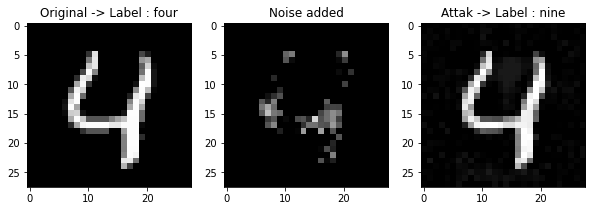

In [10]:
if model_l2.solcount > 0:
    adv_examples_l2 = [model_l2.x[0:num_pixels]]
    output_model_l2 = [model_l2.x[counter:num_var]]


    if dataset == "cifar10":
        input_ad = torch.tensor(adv_examples_l2).reshape((3, 32, 32)).type(torch.float)
        input_norm = torch.tensor(image_norm).reshape((3, 32, 32)).type(torch.float)
        input_ad2 = np.array(adv_examples_l2, dtype=np.float32).reshape([1, 32, 32, 3])
        input_norm2 = np.array(image_norm, dtype=np.float32).reshape([1, 32, 32, 3])

    if dataset == "mnist":
        input_ad = torch.tensor(adv_examples_l2).reshape((1, 28, 28)).type(torch.float)
        input_norm = torch.tensor(image_norm).reshape((1, 28, 28)).type(torch.float)
        input_ad2 = np.array(adv_examples_l2, dtype=np.float32).reshape([1, 28, 28, 1])
        input_norm2 = np.array(image_norm, dtype=np.float32).reshape([1, 28, 28, 1])
        
        
    if is_conv:
        plot_attack_pred(
            torch.from_numpy(input_norm2).permute(0, 3, 1, 2).to("cpu"),
            class_names[Image_label],
            torch.from_numpy(input_ad2).permute(0, 3, 1, 2).to("cpu"),
            class_names[adv_label],
        )
    else:
        plot_attack_pred(
            input_norm,
            class_names[Image_label],
            input_ad,
            class_names[adv_label],
        )

# The MIP-ReLUplex-gurobi attacks using $L_1$  distance measure


In [11]:
model_l1 = model

# x_l1_h_grb = m.addVars(attack_np.shape[0], lb=-float('inf'), ub=float('inf'),vtype=GRB.CONTINUOUS, name=f'x_l1_h_grb')
# x_l1_v_grb = m.addVars(attack_np.shape[0], lb=-float('inf'), ub=float('inf'),vtype=GRB.CONTINUOUS, name=f'x_l1_v_grb')
d_grb = model_l1.addVars(
    num_pixels, lb=-eps, ub=eps, vtype=GRB.CONTINUOUS, name=f"d_grb"
)
x_l1_grb = model_l1.addVars(
    num_pixels, lb=0, ub=1, vtype=GRB.CONTINUOUS, name=f"x_l1_grb"
)

expr_ln = LinExpr()

for i in range(num_pixels):
    expr_ln.add(x_l1_grb[i])

# Set objective
model_l1.setObjective(expr_ln, GRB.MINIMIZE)


for i in range(num_pixels):
    model_l1.addConstr(d_grb[i] == var_list[i] - image_norm[i], name=f"c_d_" + str(i))
    model_l1.addConstr(x_l1_grb[i] >= d_grb[i], name=f"c_x_l1_p_grb_" + str(i))
    model_l1.addConstr(x_l1_grb[i] >= -d_grb[i], name=f"c_x_l1_n_grb_" + str(i))

model_l1.setParam("OutputFlag", 1)
model_l1.setParam("TimeLimit", 1000)
model_l1.optimize()

sol_count = f"{model_l1.solcount:d}" if hasattr(model_l1, "solcount") else "None"
obj_bound = f"{model_l1.objbound:.4f}" if hasattr(model_l1, "objbound") else "failed"
obj_val = f"{model_l1.objval:.4f}" if hasattr(model_l1, "objval") else "failed"

print(
    f"MILP model status: {model_l1.Status}, Model solution count: {sol_count}, Final solve time: {model_l1.Runtime:.3f}, Final objval : {obj_val}"
)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2891 rows, 2678 columns and 47868 nonzeros
Model fingerprint: 0xc82f0b7c
Model has 106 general constraints
Variable types: 2572 continuous, 106 integer (106 binary)
Coefficient statistics:
  Matrix range     [2e-06, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-02, 4e+01]
  RHS range        [2e-04, 3e+01]
  GenCon coe range [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 9.1976 (0.15s)
Loaded MIP start from previous solve with objective 9.1976

Presolve removed 2126 rows and 1459 columns
Presolve time: 0.17s
Presolved: 765 rows, 1219 columns, 40392 nonzeros
Variable types: 1114 continuous, 105 integer (105 binary)

Root relaxation: objective 0.000000e+00, 240 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


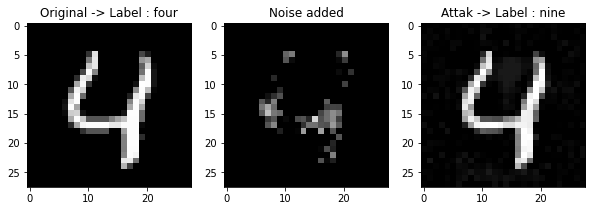

In [12]:
if model_l1.solcount > 0:
    adv_examples_l1 = [model_l1.x[0:num_pixels]]
    output_model_l1 = [model_l1.x[counter:num_var]]


    if dataset == "cifar10":
        input_ad = torch.tensor(adv_examples_l1).reshape((3, 32, 32)).type(torch.float)
        input_norm = torch.tensor(image_norm).reshape((3, 32, 32)).type(torch.float)
        input_ad2 = np.array(adv_examples_l1, dtype=np.float32).reshape([1, 32, 32, 3])
        input_norm2 = np.array(image_norm, dtype=np.float32).reshape([1, 32, 32, 3])
    if dataset == "mnist":
        input_ad = torch.tensor(adv_examples_l2).reshape((1, 28, 28)).type(torch.float)
        input_norm = torch.tensor(image_norm).reshape((1, 28, 28)).type(torch.float)
        input_ad2 = np.array(adv_examples_l2, dtype=np.float32).reshape([1, 28, 28, 1])
        input_norm2 = np.array(image_norm, dtype=np.float32).reshape([1, 28, 28, 1])
        
    if is_conv:
        plot_attack_pred(
            torch.from_numpy(input_norm2).permute(0, 3, 1, 2).to("cpu"),
            class_names[Image_label],
            torch.from_numpy(input_ad2).permute(0, 3, 1, 2).to("cpu"),
            class_names[adv_label],
        )
    else:
        plot_attack_pred(
            input_norm,
            class_names[Image_label],
            input_ad,
            class_names[adv_label],
        )

# The MIP-ReLUplex-gurobi attacks using $L_1$  distance measure + TV


In [13]:

if dataset == "cifar10":
    ff = 32
    clr = 3
if dataset == "mnist":
    ff = 28
    clr = 1




f_carre = ff * ff
par_lamda = 1.5


model_l1_tv = model_l1

# d_grb      = model_l1.addVars(num_pixels, lb = 0, ub = float('inf'), vtype = GRB.CONTINUOUS, name = f'd_grb')
# x_l1_grb   = model_l1.addVars(num_pixels, lb = 0, ub = float('inf'), vtype = GRB.CONTINUOUS, name = f'x_l1_grb')
x_l1_h_grb = model_l1_tv.addVars(
    num_pixels, lb=0, ub=float("inf"), vtype=GRB.CONTINUOUS, name=f"x_l1_h_grb"
)
x_l1_v_grb = model_l1_tv.addVars(
    num_pixels, lb=0, ub=float("inf"), vtype=GRB.CONTINUOUS, name=f"x_l1_v_grb"
)

expr_qp = QuadExpr()

for i in range(num_pixels):
    expr_qp.add(x_l1_grb[i])

for i in range(0, clr * f_carre - 1):
    if i % (ff - 1) > 0 or i == 0:
        expr_qp.add(
            par_lamda * var_list[i + 1] * var_list[i + 1]
            - 2 * par_lamda * var_list[i + 1] * var_list[i]
            + par_lamda * var_list[i] * var_list[i]
        )
for c in range(clr):
    for i in range(c * f_carre, (c + 1) * f_carre - ff):
        expr_qp.add(
            par_lamda * var_list[i + ff] * var_list[i + ff]
            - 2 * par_lamda * var_list[i + ff] * var_list[i]
            + par_lamda * var_list[i] * var_list[i]
        )


# Set objective
model_l1_tv.setObjective(expr_qp, GRB.MINIMIZE)

for i in range(num_pixels - 1):
    model_l1_tv.addConstr(
        x_l1_h_grb[i] >= d_grb[i] - d_grb[i + 1], name=f"c_x_l1_h_p_grb_" + str(i)
    )
    model_l1_tv.addConstr(
        x_l1_h_grb[i] >= -d_grb[i] + d_grb[i + 1], name=f"c_x_l1_h_n_grb_" + str(i)
    )

for i in range(num_pixels - ff):
    model_l1_tv.addConstr(
        x_l1_v_grb[i] >= d_grb[i] - d_grb[i + ff], name=f"c_x_l1_v_p_grb" + str(i)
    )
    model_l1_tv.addConstr(
        x_l1_v_grb[i] >= -d_grb[i] + d_grb[i + ff], name=f"c_x_l1_v_n_grb" + str(i)
    )


model_l1_tv.setParam("OutputFlag", 1)
model_l1_tv.setParam("TimeLimit", 1000)
model_l1_tv.optimize()

sol_count = f"{model_l1_tv.solcount:d}" if hasattr(model_l1_tv, "solcount") else "None"
obj_bound = (
    f"{model_l1_tv.objbound:.4f}" if hasattr(model_l1_tv, "objbound") else "failed"
)
obj_val = f"{model_l1_tv.objval:.4f}" if hasattr(model_l1_tv, "objval") else "failed"

print(
    f"MILP model status: {model_l1_tv.Status}, Model solution count: {sol_count}, Final solve time: {model_l1_tv.Runtime:.3f}, Final objval : {obj_val}"
)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 5969 rows, 4246 columns and 57102 nonzeros
Model fingerprint: 0xada80b76
Model has 2295 quadratic objective terms
Model has 106 general constraints
Variable types: 4140 continuous, 106 integer (106 binary)
Coefficient statistics:
  Matrix range     [2e-06, 4e+01]
  Objective range  [1e+00, 1e+00]
  QObjective range [6e+00, 2e+01]
  Bounds range     [2e-02, 4e+01]
  RHS range        [2e-04, 3e+01]
  GenCon coe range [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 89.9513 (0.03s)
Loaded MIP start from previous solve with objective 89.9513

Presolve removed 5204 rows and 3027 columns
Presolve time: 0.18s
Presolved: 765 rows, 1219 columns, 40392 nonzeros
Presolved model has 2295 quadratic objective terms
Variable types: 1114 continuous, 105 integer (105 binary)

Root relaxation: objective 6.414442e+01, 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
9
[[0.08932019152364241, 0.0, 0.0, 0.0, 6.576124609042237, 0.0, 0.0, 2.4690095788205566, 0.0, 6.676124609042237]]


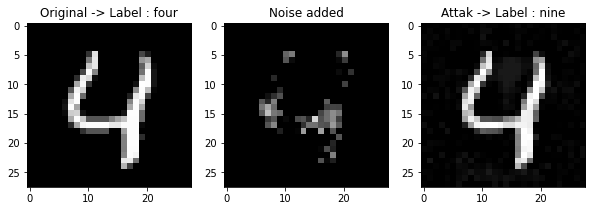

In [14]:
if model_l1_tv.solcount > 0:
    adv_examples_l1_tv = [model_l1_tv.x[0:num_pixels]]
    output_model_l1_tv = [model_l1_tv.x[counter:num_var]]


    if dataset == "cifar10":
        input_ad = torch.tensor(adv_examples_l1_tv).reshape((3, 32, 32)).type(torch.float)
        input_norm = torch.tensor(image_norm).reshape((3, 32, 32)).type(torch.float)
        input_ad2 = np.array(adv_examples_l1_tv, dtype=np.float32).reshape([1, 32, 32, 3])
        input_norm2 = np.array(image_norm, dtype=np.float32).reshape([1, 32, 32, 3])


    if is_conv:
        plot_attack_pred(
            torch.from_numpy(input_norm2).permute(0, 3, 1, 2).to("cpu"),
            class_names[Image_label],
            torch.from_numpy(input_ad2).permute(0, 3, 1, 2).to("cpu"),
            class_names[adv_label],
        )
    else:
        plot_attack_pred(
            input_norm,
            class_names[Image_label],
            input_ad,
            class_names[adv_label],
        )